## Qiskit Circuit to Tensorflow Quantum
***
The aim of the toolkit is to help users understand QAOA circuits better and also to not limit their use to a single library. As such we have added support for Google's Tensorflow Quantum ML library which can help users to run the circuit using IBM's simulator with the aid of Google's Tensorflow. We also aim to provide more support for various other ML libraries in the furture if possible.



### 1. QML on Tensorflow Quantum
***
Tensorflow quantum uses Google's Cirq library to run the quantum machine learning for QAOA circuits. Before going through the convertion process, we will go through regular process for quantum tensorflow.

First import the relvant libraries:

In [1]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import sympy

Then generate the graph for the problem, in this case we will going throught the usual MAX-CUT problem. For the graph all the weights are set 1.

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


{(0, 1): Text(0.654508480212244, 0.4755283023511464, '1.0'),
 (0, 2): Text(0.09549145273252935, 0.2938926212887637, '1.0'),
 (1, 2): Text(-0.2500000670552266, 0.7694208997980517, '1.0'),
 (2, 3): Text(-0.8090170349302954, -6.55651103964594e-08, '1.0'),
 (2, 4): Text(-0.24999999254941926, -0.18163562741820138, '1.0'),
 (3, 4): Text(-0.24999993294477343, -0.7694209117189807, '1.0')}

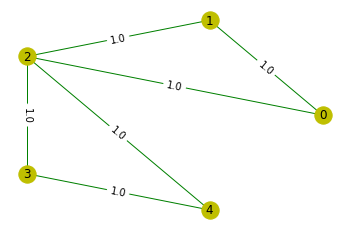

In [2]:
# Create a graph for the problem its is also adviseable to instantiate the weight of the graphs else it 
# be defaulted to 1
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0))
labels = nx.get_edge_attributes(G,'weight')

nx.draw(G,with_labels=True, pos=nx.circular_layout(G), node_color='y', edge_color='g')
nx.draw_networkx_edge_labels(G,nx.circular_layout(G),edge_labels=labels)

Just like in qiskit, in Cirq we need to declare the number of qubits, in Cirq we are given the option of choosing the qubit arrangement, for this case we will choose grid arragement for the qubits:

In [3]:
cirq_qubits = cirq.GridQubit.rect (1 , G.number_of_nodes())

Initialize the initial hadamrd gates to put the qubits in equal superposition and this portion of the circuit will also serve as the input tensor for tensorflow to perform the optimization

In [4]:
hadamard_circuit = cirq.Circuit ()

for node in G.nodes ():
    qubit = cirq_qubits [ node ]
    hadamard_circuit.append(cirq.H.on(qubit))
    
hadamard_circuit

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───

Just like in the toolkit, we have to generate the Cost and Mixer hamitlonians serperately. Cirq uses sympy to map the symbols to the circuit parameters. The Cost and Mixer Hamiltonians in this case is expressed as cirq's PauliSum expression which can be converted to a circuit later. This is done so that the cost hamitlonian can used to calculate the expectation value when running the optimization process.

In [5]:
# Cirq uses sympy to denote the hyperparameters, Gamma(g) and Beta(b)
qaoa_parameters = sympy.symbols('g,b')

# Generte the mixer hamiltonian using Cirq Gates
mixing_ham = 0
for node in G.nodes():
    qubit = cirq_qubits[node]
    mixing_ham += cirq.PauliString(cirq.X(qubit))
    
print(mixing_ham)

1.000*X((0, 0))+1.000*X((0, 1))+1.000*X((0, 2))+1.000*X((0, 3))+1.000*X((0, 4))


In [6]:
cost_ham = G.number_of_edges()/2

for edge in G.edges () :
    qubit1 = cirq_qubits [edge[0]]
    qubit2 = cirq_qubits [edge[1]]
    cost_ham += cirq.PauliString(1/2*( cirq.Z(qubit1)*cirq.Z( qubit2 )))
    
print(cost_ham)

0.500*Z((0, 0))*Z((0, 1))+3.000*I+0.500*Z((0, 0))*Z((0, 2))+0.500*Z((0, 1))*Z((0, 2))+0.500*Z((0, 2))*Z((0, 3))+0.500*Z((0, 2))*Z((0, 4))+0.500*Z((0, 3))*Z((0, 4))


Finally, we can convert the PauliSums into a quantum circuit using tfq's exponential() function which converts the PauliSum objects to circuits and maps the parameters to the relavant parametric gates via exponentiation.

In [7]:
qaoa_circuit = tfq.util.exponential (operators=[cost_ham, mixing_ham], coefficients=qaoa_parameters)
qaoa_circuit

(0, 0): ───@───────────────@───X───Z^(-0.954929658551372*g)───X───Z^(-0.954929658551372*g)───@───────────────@───────────────────────────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────────────────────────────────────────────────────────────────
           │               │                                                                 │               │
(0, 1): ───X───Rz(1.0*g)───X─────────────────────────────────────────────────────────────────┼───────────────┼───@───────────────@───────────────────────────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────────────────────────────────────────────
                                                                                             │               │   │               │
(0, 2): ─────────────────────────────────────────────────────────────────────────────────────X───Rz(1.0*g)───X───X───Rz(1.0*g)───X───@───────────────@───@───────────────@───────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────────────────────────
                                                                                                                                     │               │   │               │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(1.0*g)───X───┼───────────────┼───@───────────────@───────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────
                                                                                                                                                         │               │   │               │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(1.0*g)───X───X───Rz(1.0*g)───X───────────────────────────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───

In [8]:
# define the model and training data
model_circuit , model_readout = qaoa_circuit, cost_ham
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)

Now we have to build the keras model using tensorflow. However, the quantum circuit can be converted into the quantum tensor by using PQC function(Paramteric Quantum Circuit) function to convert the circuit into tensors and layers for the optimization process.

In [9]:
optimum = [0]

# Build the Keras model .
optimum = np.array(optimum)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string ))
model.add(tfq.layers.PQC(model_circuit, model_readout ))

Now we run the process and find out the optimal hyperparamters using the Adam optimizer:

In [10]:
model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=tf.keras.optimizers.Adam())

history = model.fit(input_, optimum, epochs=1000 ,verbose=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 1s 1s/sample - loss: 2.7427
Epoch 2/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7381
Epoch 3/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7334
Epoch 4/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7288
Epoch 5/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.7241
Epoch 6/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.7195
Epoch 7/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7149
Epoch 8/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.7103
Epoch 9/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7057
Epoch 10/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7012
Epoch 11/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.6966
Epoch 12/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.6921
Epoch 1

Epoch 101/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3624
Epoch 102/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3596
Epoch 103/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3568
Epoch 104/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3541
Epoch 105/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.3513
Epoch 106/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3486
Epoch 107/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3459
Epoch 108/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.3432
Epoch 109/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3405
Epoch 110/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3378
Epoch 111/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.3352
Epoch 112/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3326
Epoc

Epoch 200/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1686
Epoch 201/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1674
Epoch 202/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1662
Epoch 203/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1650
Epoch 204/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1638
Epoch 205/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1627
Epoch 206/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1615
Epoch 207/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1604
Epoch 208/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1593
Epoch 209/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1582
Epoch 210/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1571
Epoch 211/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1560
Epoc

Epoch 299/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0958
Epoch 300/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0954
Epoch 301/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0951
Epoch 302/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0947
Epoch 303/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0944
Epoch 304/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0940
Epoch 305/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0936
Epoch 306/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0933
Epoch 307/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0930
Epoch 308/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0926
Epoch 309/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0923
Epoch 310/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0920
Epoc

Epoch 398/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0759
Epoch 399/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0758
Epoch 400/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0757
Epoch 401/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0756
Epoch 402/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0755
Epoch 403/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.0755
Epoch 404/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0754
Epoch 405/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0753
Epoch 406/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0752
Epoch 407/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0752
Epoch 408/1000
1/1 [==============================] - 0s 5ms/sample - loss: 2.0751
Epoch 409/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0750
Epoc

Epoch 497/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0719
Epoch 498/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0719
Epoch 499/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0718
Epoch 500/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0718
Epoch 501/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0718
Epoch 502/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0718
Epoch 503/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0718
Epoch 504/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0718
Epoch 505/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0718
Epoch 506/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0718
Epoch 507/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0717
Epoch 508/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0717
Epoc

Epoch 596/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 597/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 598/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 599/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 600/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0713
Epoch 601/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0713
Epoch 602/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 603/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 604/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0713
Epoch 605/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0713
Epoch 606/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 607/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoc

Epoch 695/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 696/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 697/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 698/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 699/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 700/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 701/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 702/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 703/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 704/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 705/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 706/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoc

Epoch 794/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 795/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 796/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 797/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 798/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 799/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 800/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 801/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 802/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 803/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 804/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 805/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoc

Epoch 893/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 894/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 895/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 896/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 897/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 898/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 899/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 900/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 901/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 902/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 903/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 904/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoc

Epoch 992/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 993/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 994/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 995/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 996/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 997/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 998/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0712
Epoch 999/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712
Epoch 1000/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0712


Now we can extract the parameters and run the circuit using Tensorflow quantum's *sample_layer*, which is slighty different from cirq's simulator. This would return the a list of bitstrings and the number of occurance of the bitstring is the probability:

In [11]:
# Read out the optimal paramters and sample from the final state 1000 times
params = model.trainable_variables
print(params)
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append=qaoa_circuit )

sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit, symbol_names=qaoa_parameters, symbol_values=params, repetitions=1000)

[<tf.Variable 'parameters:0' shape=(2,) dtype=float32, numpy=array([2.8200622, 3.728577 ], dtype=float32)>]
Instructions for updating:
reduction_indices is deprecated, use axis instead


Finally, with some post-processing we can find the max cuts for the graph above and the approximation ratio $\alpha$:

In [12]:
# Translate output in cut sets
cuts_qaoa = []
for bit_string in output.values:
    temp = []
    for pos, bit in enumerate(bit_string):
        if bit==1:
            temp.append(pos)
            cuts_qaoa.append(temp)

# Generate a list with all possible subsets
from itertools import combinations
sub_lists = []
for i in range(0, len(G.nodes())+1):
    temp = [list(x) for x in combinations(G.nodes(), i)]
    sub_lists.extend(temp)
    
    
cut_size = []
for sub_list in sub_lists:
    cut_size.append(nx.algorithms.cuts.cut_size(G,sub_list))

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
    cut_size_qaoa.append(nx.algorithms.cuts.cut_size(G,cut))

# Calculate the approximation ratio
print(np.mean(cut_size_qaoa), np.max(cut_size))
np.mean(cut_size_qaoa)/np.max(cut_size)

3.3742088607594938 4


0.8435522151898734

### Converting QAOAToolkit for Tensorflow:
****
Now to understand the convertion process and issue that inherent in it, we shall first start by using the QAOAToolkit:

In [13]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham
from hamiltonian import mixer_hamiltonian as mix_ham
from expectation_value import expectation_value as ex_vle
from utils.tfq_helper import tfq_helper as helper

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

In [14]:
# Classical objective function for the max-cut problem
obj_function = 'x_u + x_v - 2*x_u*x_v'
variables = ['x_v','x_u']

In [15]:
phase_h = phs_ham(obj_function,variables)
phase_h.get_objFun()

-2*x_u*x_v + x_u + x_v

In [16]:
phase_h.Hamify()
phase_h.get_pHamil()

0.5*I - 0.5*Z_u*Z_v

Following the Toolkit's procedure we can generate the circuits, but in this case since qiskit conversion to QASM2.0 causes error when we replace the hyperparameters with **Sympy Symbols**, therefore, we will have to set the parameters to 1.0, also the new added feature of the expanded Pauli Sum is also provided to further improve the support for tfq tensors: 

**Note this support is limited to p-steps = 1**

In [17]:
# Declare the hyperparameters
gammas = [1]
betas  = [1]

# Instance of the mixer hamiltonian
mx_ham = mix_ham()

# Map both the Mixer and Cost Hamiltonian
phase_h.perEdgeMap(gammas, 1, G, False, False)
phase_hMap = phase_h.qubit_map

mx_ham.generalXMixer(betas,1, phase_hMap, False)
phase_h.get_pHamil()

3.0*I - 0.5*Z_0*Z_1 - 0.5*Z_0*Z_2 - 0.5*Z_1*Z_2 - 0.5*Z_2*Z_3 - 0.5*Z_2*Z_4 - 0.5*Z_3*Z_4

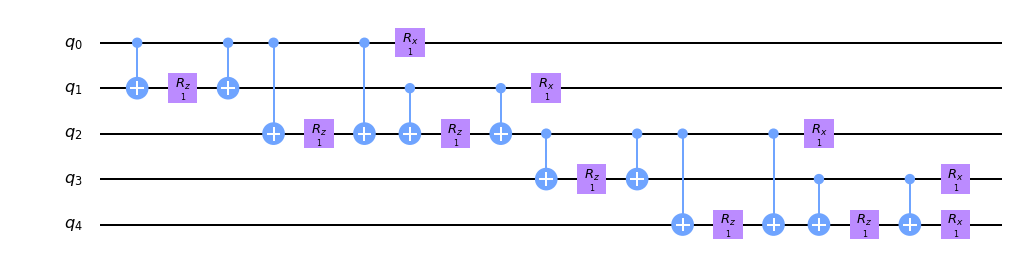

In [18]:
full = phase_h / mx_ham
full.draw(output='mpl')

Tensorflow Quantum requires the input tensor to be an array of Hadamard gates,since the this implementation of hadamard gates is trivial one can set it up using Google's Cirq directly:

In [19]:
# From the Tfq/Cirq example above 
hadamard_circuit

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───

However, if you already have the circuit set-up in IBM's Qiskit, you can use the *tfq_helper* functions: *to_tfq_circuit()* to convert the qiskit.QuantumCircuit to Cirq.Circuit via **QASM2.0** which returns a **tuple(Cirq.Circuit,None)**,the 2nd object in the tuple will be discussed later:

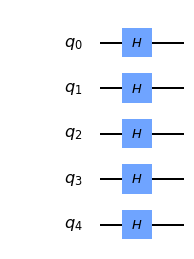

In [20]:
# Set up hadamard ciruit using Qiskit
cir_h = QuantumCircuit(G.number_of_nodes())
for nodes in G.nodes():
    cir_h.h(nodes)
cir_h.draw(output='mpl')

In [21]:
cirq_cir_hadamard = helper.to_tfq_circuit(cir_h)[0]
cirq_cir_hadamard

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───

The Phase Hamiltonian and Mixer Hamiltonian objects can also be converted using the *to_tfq_circuit()* function, this function is vital as by simply convetrting using QASM method will result in an error.
The issue lies in the fact that the names of qubits converted from **QASM2.0** is treated as **named qubits**, but tensorflow quantum requires the qubit type to be **GridQubit** arrangement so that it can be converted into a tensor. Furthermore, with the symboli hypereparameters, tfq will not be able to tune the values to find the optimal solution.

For the phase Hamiltonian, tfq requires a Cirq.PauliString expression to calculate the expectation value of the circuit. When a phase_hamiltonian object is passed through the function, the p_hamil expression is also converted into a Cirq.PauliString as the 2nd object in the tuple:

In [22]:
cirq_phase = helper.to_tfq_circuit(phase_h)
cirq_phase[0]

(0, 0): ───@────────────────@───@────────────────@───────────────────────────────────────────────────────────────────────────────────────
           │                │   │                │
(0, 1): ───X───Rz(0.318π)───X───┼────────────────┼───@────────────────@──────────────────────────────────────────────────────────────────
                                │                │   │                │
(0, 2): ────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───@────────────────@───@────────────────@────────────────────────
                                                                          │                │   │                │
(0, 3): ──────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───┼────────────────┼───@────────────────@───
                                                                                               │                │   │                │
(0, 4): ───────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───

In [23]:
print(cirq_phase[1])

1.000*I+0.500*Z((0, 0))*Z((0, 1))+0.500*Z((0, 0))*Z((0, 2))+0.500*Z((0, 1))*Z((0, 2))+0.500*Z((0, 2))*Z((0, 3))+0.500*Z((0, 2))*Z((0, 4))+0.500*Z((0, 3))*Z((0, 4))


Likewise for the Mixer Hamiltonian class but will also return **none** for the 2nd object in the tuple:

In [24]:
cirq_mixer = helper.to_tfq_circuit(mx_ham)[0]
cirq_mixer

(0, 0): ───Rx(0.318π)───

(0, 1): ───Rx(0.318π)───

(0, 2): ───Rx(0.318π)───

(0, 3): ───Rx(0.318π)───

(0, 4): ───Rx(0.318π)───

Since, the both the circuits have been converted into Cirq.Circuit form, one can observe that the hyperparameters are still missing in the circuits,fret not, the tfq_helper class has function called *exponentiate_parameters()* which maps a list of parameters into the cirq.Circuit. You only need a list of hyperparameters as **string** and the full quantum circuit of the problem; you have to combine both the circuits from the phase hamiltonian and the mixer hamiltonian:

In [25]:
#Combine both the circuits
full_circuit = cirq_phase[0] + cirq_mixer
full_circuit

(0, 0): ───@────────────────@───@────────────────@───────────────────────────────────────────────────────────────────────────────────────Rx(0.318π)───
           │                │   │                │
(0, 1): ───X───Rz(0.318π)───X───┼────────────────┼───@────────────────@──────────────────────────────────────────────────────────────────Rx(0.318π)───
                                │                │   │                │
(0, 2): ────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───@────────────────@───@────────────────@────────────────────────Rx(0.318π)───
                                                                          │                │   │                │
(0, 3): ──────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───┼────────────────┼───@────────────────@───Rx(0.318π)───
                                                                                               │                │   │                │
(0, 4): ───────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───Rx(0.318π)───

In [26]:
# Declare a list of hyperparameters, gamma (g), beta(b)
hyperparams = ['g','b']

full_circuit_param = helper.exponentiate_parameters(hyperparams, full_circuit)
full_circuit_param

(0, 0): ───@────────────────────────────────@───@────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(0.318309886183791*pi*b)───
           │                                │   │                                │
(0, 1): ───X───Rz(0.318309886183791*pi*g)───X───┼────────────────────────────────┼───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(0.318309886183791*pi*b)───
                                                │                                │   │                                │
(0, 2): ────────────────────────────────────────X───Rz(0.318309886183791*pi*g)───X───X───Rz(0.318309886183791*pi*g)───X───@────────────────────────────────@───@────────────────────────────────@────────────────────────────────────────Rx(0.318309886183791*pi*b)───
                                                                                                                          │                                │   │                                │
(0, 3): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318309886183791*pi*g)───X───┼────────────────────────────────┼───@────────────────────────────────@───Rx(0.318309886183791*pi*b)───
                                                                                                                                                               │                                │   │                                │
(0, 4): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318309886183791*pi*g)───X───X───Rz(0.318309886183791*pi*g)───X───Rx(0.318309886183791*pi*b)───

Viola! Now we can follow the typical procedure of using TFQ to find the optimial hyperparameters:

In [27]:
#Declare the input  Hadamard Tensor
input_tensor = [cirq_cir_hadamard]
input_tensor = tfq.convert_to_tensor(input_tensor)

optimum = [0]
model_circuit = full_circuit_param
model_readout = cirq_phase[1]

# Build the Keras model .
optimum = np.array(optimum)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string ))
model.add(tfq.layers.PQC(model_circuit, model_readout ))


model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=tf.keras.optimizers.Adam())

history = model.fit(input_, optimum, epochs=1000 ,verbose=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 0s 481ms/sample - loss: 1.8233
Epoch 2/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.8198
Epoch 3/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.8163
Epoch 4/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.8128
Epoch 5/1000
1/1 [==============================] - 0s 3ms/sample - loss: 1.8093
Epoch 6/1000
1/1 [==============================] - 0s 3ms/sample - loss: 1.8057
Epoch 7/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.8022
Epoch 8/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.7987
Epoch 9/1000
1/1 [==============================] - 0s 3ms/sample - loss: 1.7951
Epoch 10/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.7916
Epoch 11/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.7880
Epoch 12/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.7844
Epoc

Epoch 101/1000
1/1 [==============================] - 0s 3ms/sample - loss: 1.4377
Epoch 102/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4336
Epoch 103/1000
1/1 [==============================] - 0s 3ms/sample - loss: 1.4295
Epoch 104/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4253
Epoch 105/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4212
Epoch 106/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4171
Epoch 107/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4130
Epoch 108/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4088
Epoch 109/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4047
Epoch 110/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.4006
Epoch 111/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.3964
Epoch 112/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.3923
Epoc

Epoch 200/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0403
Epoch 201/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0366
Epoch 202/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0329
Epoch 203/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0292
Epoch 204/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0255
Epoch 205/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0219
Epoch 206/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0182
Epoch 207/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0146
Epoch 208/1000
1/1 [==============================] - 0s 5ms/sample - loss: 1.0109
Epoch 209/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0073
Epoch 210/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0037
Epoch 211/1000
1/1 [==============================] - 0s 2ms/sample - loss: 1.0000
Epoc

Epoch 299/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7275
Epoch 300/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7249
Epoch 301/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7224
Epoch 302/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7199
Epoch 303/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7173
Epoch 304/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.7148
Epoch 305/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7124
Epoch 306/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.7099
Epoch 307/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7074
Epoch 308/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.7050
Epoch 309/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7025
Epoch 310/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7001
Epoc

Epoch 398/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5287
Epoch 399/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.5272
Epoch 400/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5257
Epoch 401/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5242
Epoch 402/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5226
Epoch 403/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5211
Epoch 404/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5196
Epoch 405/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5182
Epoch 406/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5167
Epoch 407/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5152
Epoch 408/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.5137
Epoch 409/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.5123
Epoc

Epoch 497/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4052
Epoch 498/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4042
Epoch 499/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4031
Epoch 500/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4021
Epoch 501/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4011
Epoch 502/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4001
Epoch 503/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3991
Epoch 504/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3980
Epoch 505/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3970
Epoch 506/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3960
Epoch 507/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3950
Epoch 508/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3940
Epoc

Epoch 596/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3151
Epoch 597/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3142
Epoch 598/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3134
Epoch 599/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3126
Epoch 600/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.3118
Epoch 601/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.3110
Epoch 602/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3102
Epoch 603/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3094
Epoch 604/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3086
Epoch 605/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3078
Epoch 606/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.3070
Epoch 607/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.3062
Epoc

Epoch 695/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2422
Epoch 696/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2415
Epoch 697/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2408
Epoch 698/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2402
Epoch 699/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2395
Epoch 700/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2389
Epoch 701/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2382
Epoch 702/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2376
Epoch 703/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2369
Epoch 704/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2363
Epoch 705/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2356
Epoch 706/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2350
Epoc

Epoch 794/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1844
Epoch 795/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1839
Epoch 796/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1834
Epoch 797/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1829
Epoch 798/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1824
Epoch 799/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1819
Epoch 800/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1814
Epoch 801/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1809
Epoch 802/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1804
Epoch 803/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.1800
Epoch 804/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1795
Epoch 805/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1790
Epoc

Epoch 893/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1419
Epoch 894/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1415
Epoch 895/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1411
Epoch 896/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1408
Epoch 897/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1404
Epoch 898/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.1401
Epoch 899/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1397
Epoch 900/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1394
Epoch 901/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1390
Epoch 902/1000
1/1 [==============================] - 0s 4ms/sample - loss: 0.1387
Epoch 903/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1383
Epoch 904/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1380
Epoc

Epoch 992/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1127
Epoch 993/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1125
Epoch 994/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1123
Epoch 995/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1120
Epoch 996/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.1118
Epoch 997/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1116
Epoch 998/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1114
Epoch 999/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1111
Epoch 1000/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1109


Now that we have obtained the paramters we can run it on the quantum circuit/simulator on Qiskit Aer:

[<tf.Variable 'parameters:0' shape=(2,) dtype=float32, numpy=array([3.9110522, 2.6042774], dtype=float32)>]


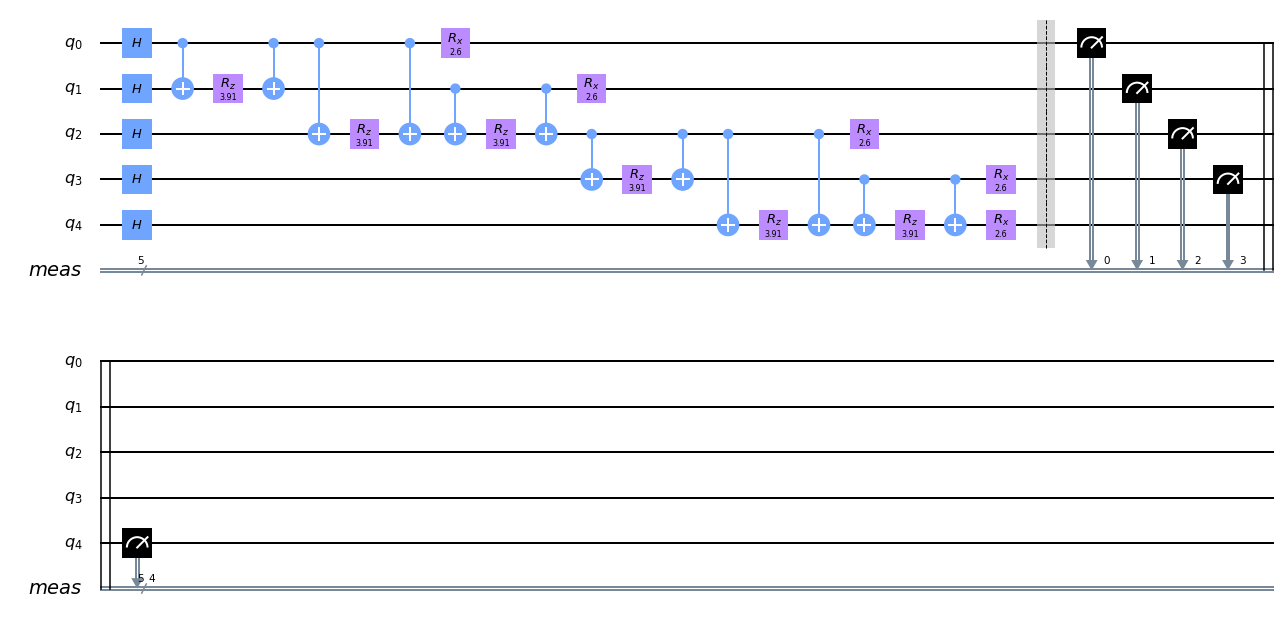

In [28]:
params = model.trainable_variables

print(params)

phase_h.perEdgeMap([params[0].numpy()[0]],1, G, False, False)
mx_ham.generalXMixer([params[0].numpy()[1]],1, phase_hMap, True)

# Add the hadamard circuit back and cost and mixer hamltonians
cir_opt = cir_h + phase_h / mx_ham
cir_opt.draw(output='mpl')

In [29]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import execute
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

res_graph = ex_vle(obj_function,variables,is_graph=True)

# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 1024

simulate     = execute(cir_opt, backend=backend, shots=shots)
results = simulate.result()
mx_c = res_graph.get_expectationValue(results,shots,G)
print('Expectation value:', mx_c)
print('Approximation Ratio:',mx_c/ np.max(cut_size))

Expectation value: 3.8671875
Approximation Ratio: 0.966796875


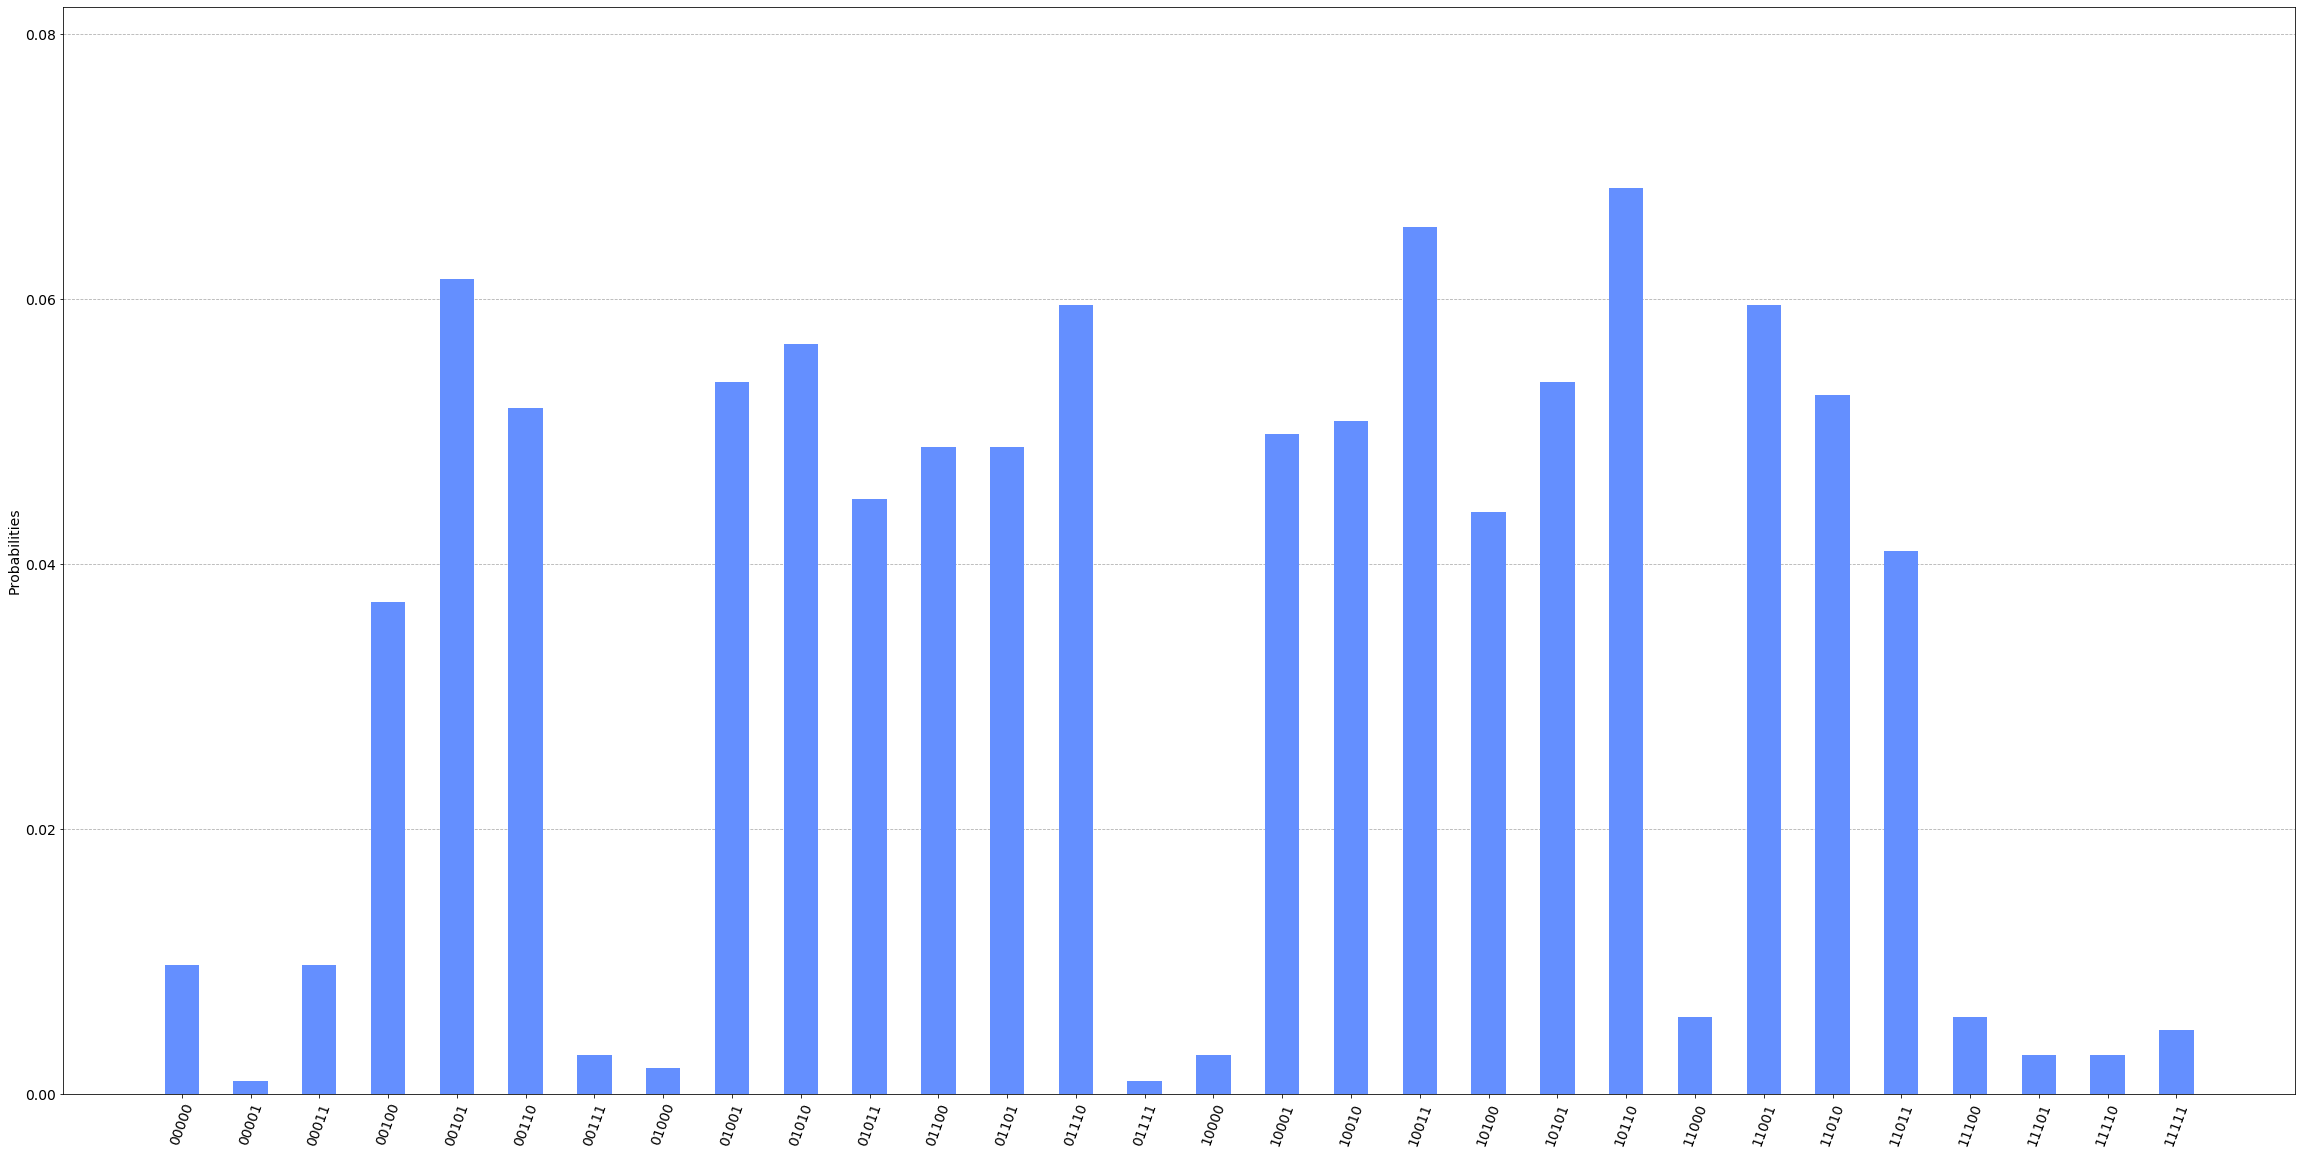

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram(results.get_counts(),figsize = (40,20),bar_labels = False)

## Using a classical optimizer
***
Just for comparision we will use SciPy Optimizers to see how it fares aganist the tfq ML optimization, using 'Predefined_Example's' MAX_CUT problem.

If we compare to the **scipy** optimizer for this particular graph, it would seem that both are fairly good at optimizing the hyperparameters.Using the Predefined Examples we can get a expectation value of the circuit using the classical optimizer, however, in this case one should take note: The **starting hyperparameters** will affect the results of the program which is unlike tfq which does not require a good starting point:

In [31]:
# import the predefined library
import os 
os.path.abspath(os.curdir)
os.path.sys.path.append('../predefined_problems/')

import max_cut as mc

# instantiate a MAX_CUT object which prepares converts the objective function into a pauli hamiltonian
max_cut = mc.max_cut(1,G)

hyperparams=[np.pi, np.pi]
opt_hyperparams = max_cut.run_QAOA(hyperparams,'COBYLA')

max_cut.generate_quantumCircuit(G, opt_hyperparams)
res = max_cut.run_circuit()

print('approximation ratio:',res_graph.get_expectationValue(res,shots,G)/np.max(cut_size) )

     fun: -3.921875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([3.8402492 , 2.48642654])
backend setup: Complete running circuit
Simulation: Complete!
Expectation Value : 3.888671875
approximation ratio: 0.97216796875


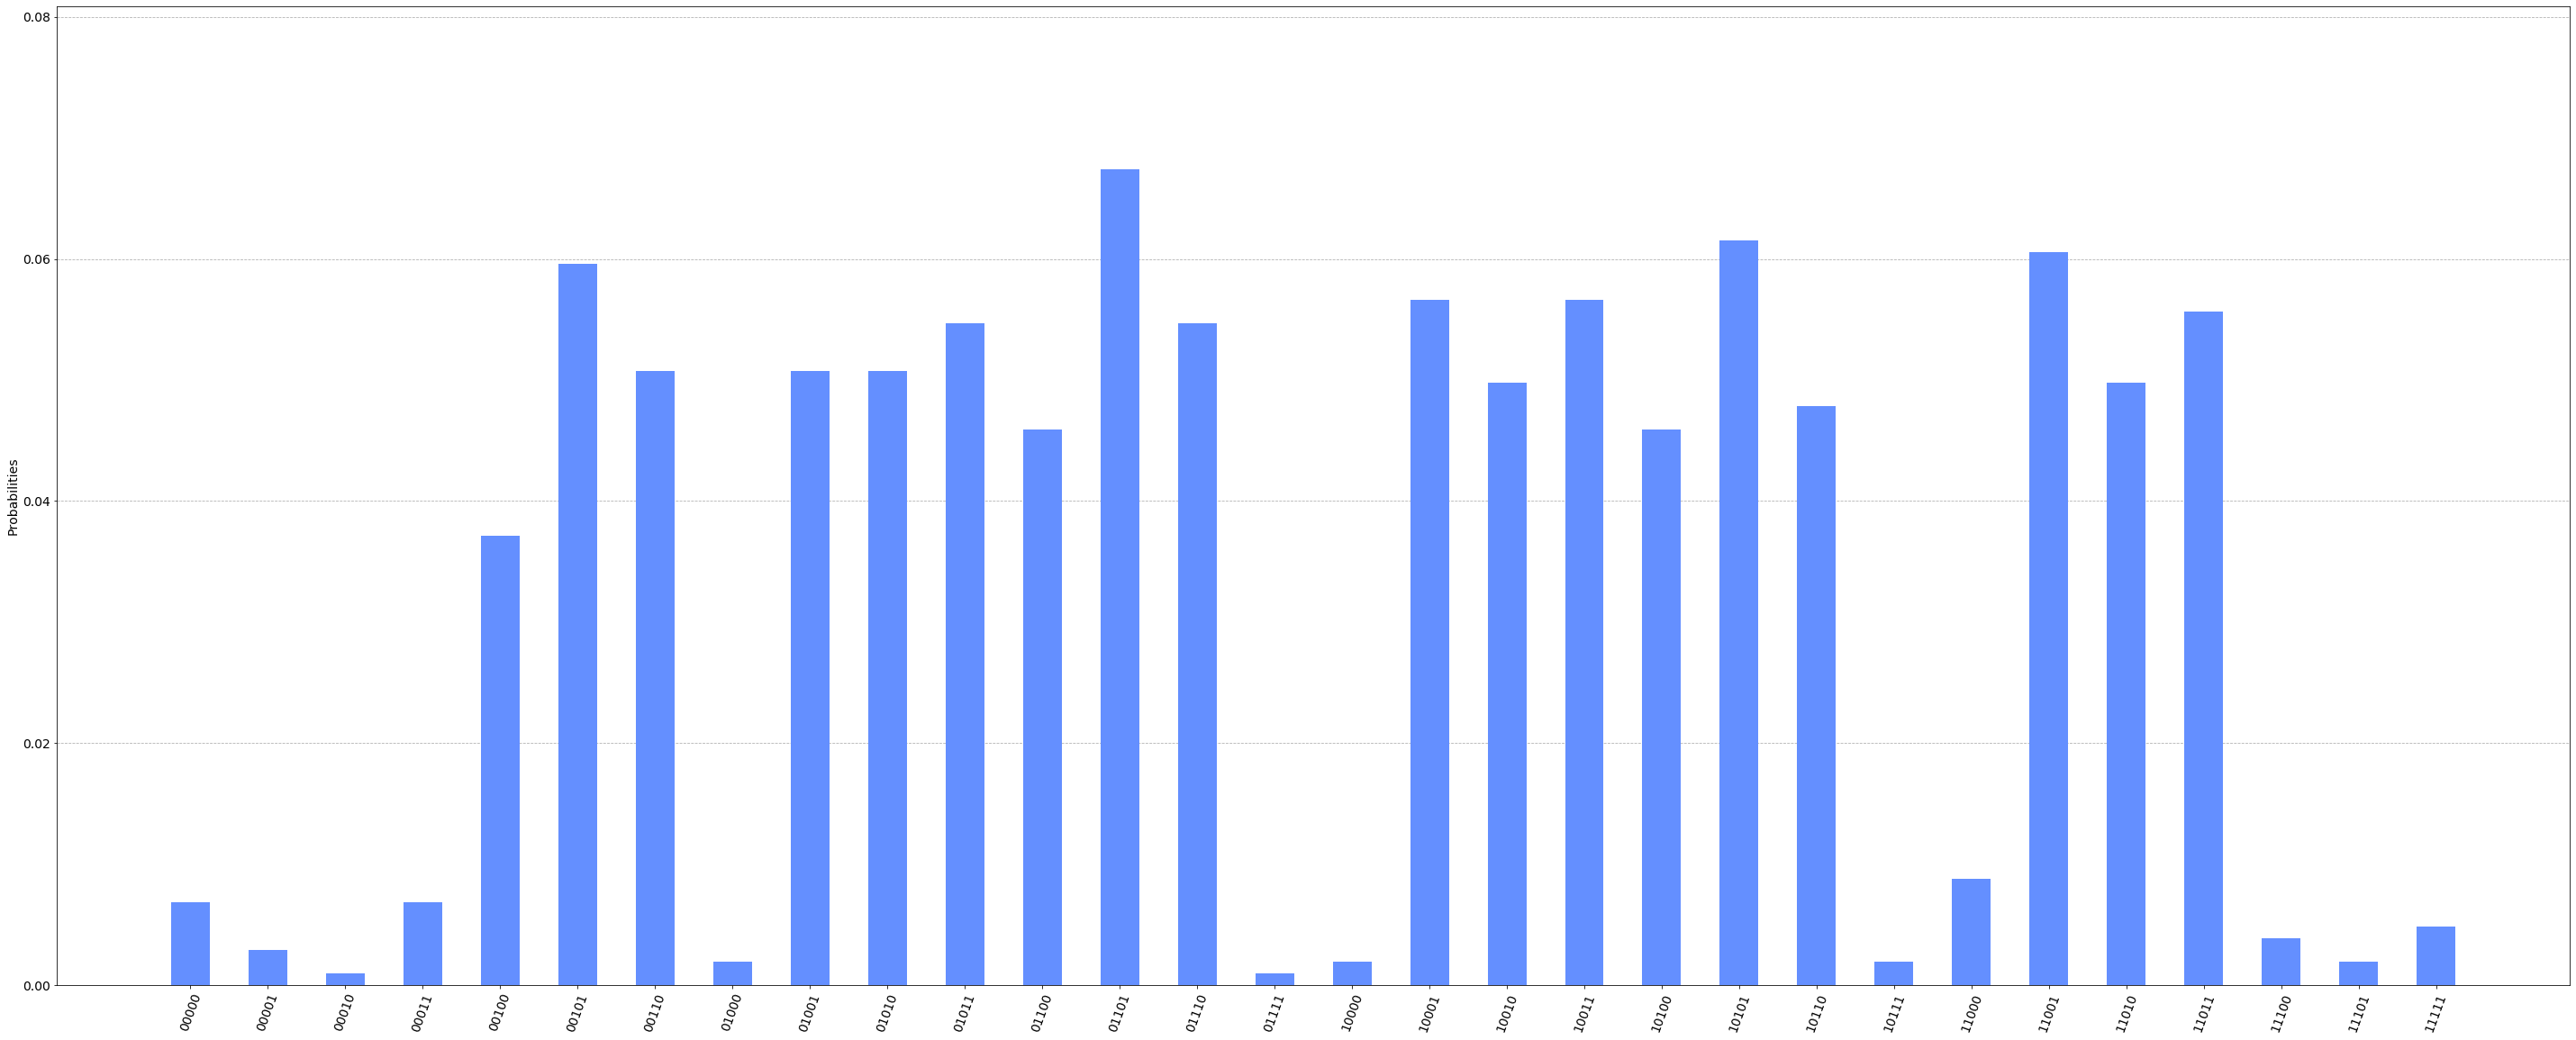

In [32]:
from qiskit.visualization import plot_histogram
plot_histogram(res.get_counts(),figsize = (50,20),bar_labels = False)

Each optimizer's performance may vary on a case-by-case basis, however, the current **tfq_helper** class can only support up to **P=1** steps, unlike **SciPy** Optimizer which can support for **P>1**. In later versions of the toolkit will add a support for users who wish to use higher number of p-steps for the circuits